**Generowanie i analiza danych - pierwszy notebook! (link: https://github.com/jakubtwalczak/Polish-people-basic-physical-attributes/blob/main/Polish_people_physical_attributes.ipynb)**

# Przygotowania - import bibliotek, wczytanie zbioru danych.



In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler, LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier, RandomForestClassifier, StackingRegressor
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.svm import LinearSVR
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings("ignore")

In [2]:
def load_dataset(filename, index_col=None):
    dataset = pd.read_csv(f'{filename}', index_col=index_col)
    pd.options.display.max_columns = None
    return dataset

url = 'https://raw.githubusercontent.com/jakubtwalczak/Polish-people-basic-physical-attributes/main/Polish_height_weight_bmi.csv'

df = load_dataset(filename=url)
df

,Height,BMI,Sex,Weight
0,173.0,29.70,Male,88.9
1,175.8,34.24,Male,105.8
2,174.1,27.57,Male,83.6
3,179.9,25.90,Male,83.8
4,184.6,26.72,Male,91.1
...,...,...,...,...
9995,176.0,22.38,Female,69.3
9996,169.0,27.36,Female,78.1
9997,155.7,25.05,Female,60.7
9998,181.3,24.38,Female,80.1


# Klasyfikacja.

## Podział na predyktory i etykiety.

In [3]:
X_clas = df.drop(columns=['Sex', 'BMI'])
y_clas = df['Sex']

In [4]:
X_clas

,Height,Weight
0,173.0,88.9
1,175.8,105.8
2,174.1,83.6
3,179.9,83.8
4,184.6,91.1
...,...,...
9995,176.0,69.3
9996,169.0,78.1
9997,155.7,60.7
9998,181.3,80.1


In [5]:
y_clas

0         Male
1         Male
2         Male
3         Male
4         Male
         ...  
9995    Female
9996    Female
9997    Female
9998    Female
9999    Female
Name: Sex, Length: 10000, dtype: object

## Kodowanie etykiet.

In [6]:
le = LabelEncoder()
y_clas = le.fit_transform(y_clas)
y_clas

array([1, 1, 1, ..., 0, 0, 0])

## Podział na dane treningowe i testowe.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_clas, y_clas, test_size=0.2, random_state=100, stratify=y_clas)

## Model blendingowy.

In [8]:
%%time

base_models = [
    ('Random Forest', RandomForestClassifier(), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20]}),
    ('Decision Tree Classifier', DecisionTreeClassifier(), {'max_depth': [None, 10, 20], 'min_samples_split': [2, 5, 10]}),
    ('AdaBoost Classifier', AdaBoostClassifier(), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]}),
    ('Logistic Regression', make_pipeline(RobustScaler(), PolynomialFeatures(), LogisticRegression()),
     {'logisticregression__C': [0.1, 1, 10], 'logisticregression__penalty': ['l1', 'l2'],
      'polynomialfeatures__degree': [1, 2, 3]}),
]

meta_model = XGBClassifier()

predictions_train = []
predictions_test = []

for name, model, params in base_models:
    if name == 'Logistic Regression':
        poly_model = make_pipeline(RobustScaler(), PolynomialFeatures(), LogisticRegression())
        grid_search = GridSearchCV(poly_model, params, cv=3, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_

        train_pred = best_model.predict(X_train)
        test_pred = best_model.predict(X_test)

        print(f'{name} (Polynomial Degree {grid_search.best_params_["polynomialfeatures__degree"]}) - Best Parameters: {grid_search.best_params_}')
        print(f'{name} training accuracy: {accuracy_score(y_train, train_pred)}')
        print(f'{name} test accuracy: {accuracy_score(y_test, test_pred)}')
        print('_____________________________________________________\n')

        predictions_train.append(train_pred.reshape(-1, 1))
        predictions_test.append(test_pred.reshape(-1, 1))
    else:
        grid_search = GridSearchCV(model, params, cv=3, scoring='accuracy')
        grid_search.fit(X_train, y_train)

        best_model = grid_search.best_estimator_

        train_pred = best_model.predict(X_train)
        test_pred = best_model.predict(X_test)

        print(f'{name} - Best Parameters: {grid_search.best_params_}')
        print(f'{name} training accuracy: {accuracy_score(y_train, train_pred)}')
        print(f'{name} test accuracy: {accuracy_score(y_test, test_pred)}')
        print('_____________________________________________________\n')

        predictions_train.append(train_pred.reshape(-1, 1))
        predictions_test.append(test_pred.reshape(-1, 1))

predictions_train = np.hstack(predictions_train)
predictions_test = np.hstack(predictions_test)
meta_params = {'n_estimators': [50, 100, 200], 'max_depth': [3, 5, 7, 9], 'learning_rate': [0.01, 0.1, 0.2]}
meta_model.fit(predictions_train, y_train)

meta_model_grid_search = GridSearchCV(meta_model, meta_params, cv=3, scoring='accuracy')
meta_model_grid_search.fit(predictions_train, y_train)

best_meta_model = meta_model_grid_search.best_estimator_
blending_predictions = best_meta_model.predict(predictions_test)

print(f'Meta Model (XGBClassifier) - Best Parameters: {meta_model_grid_search.best_params_}')
print(f'Blending model accuracy: {accuracy_score(y_test, blending_predictions)}')

Random Forest - Best Parameters: {'max_depth': 10, 'n_estimators': 100}
Random Forest training accuracy: 0.91425
Random Forest test accuracy: 0.8715
_____________________________________________________

Decision Tree Classifier - Best Parameters: {'max_depth': 10, 'min_samples_split': 10}
Decision Tree Classifier training accuracy: 0.896
Decision Tree Classifier test accuracy: 0.8555
_____________________________________________________

AdaBoost Classifier - Best Parameters: {'learning_rate': 0.1, 'n_estimators': 50}
AdaBoost Classifier training accuracy: 0.869875
AdaBoost Classifier test accuracy: 0.8725
_____________________________________________________

Logistic Regression (Polynomial Degree 3) - Best Parameters: {'logisticregression__C': 0.1, 'logisticregression__penalty': 'l2', 'polynomialfeatures__degree': 3}
Logistic Regression training accuracy: 0.8675
Logistic Regression test accuracy: 0.875
_____________________________________________________

Meta Model (XGBClassifier)

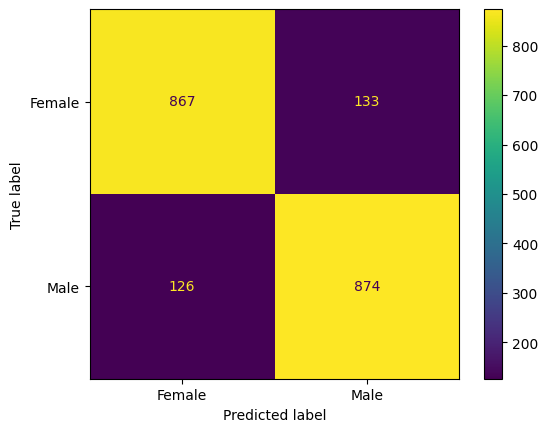

In [9]:
cm = confusion_matrix(y_test, blending_predictions)
ConfusionMatrixDisplay(cm, display_labels=['Female', 'Male']).plot()

## Model stackingowy.

In [10]:
%%time

base_models = [
    ('Random Forest', RandomForestClassifier(max_depth=10, n_estimators=100)),
    ('Decision Tree Classifier', DecisionTreeClassifier(max_depth=10, min_samples_split=10)),
    ('AdaBoost Classifier', AdaBoostClassifier(learning_rate=0.1, n_estimators=50)),
    ('Logistic Regression', LogisticRegression(C=1, penalty='l2')),
]

meta_model_clas = XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=50)

stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model_clas)
stacking_model.fit(X_train, y_train)
stacking_predictions = stacking_model.predict(X_test)
accuracy = stacking_model.score(X_test, y_test)
print(f"Stacking model accuracy: {accuracy}")

Stacking model accuracy: 0.8755
CPU times: user 6.79 s, sys: 419 ms, total: 7.21 s
Wall time: 6.97 s


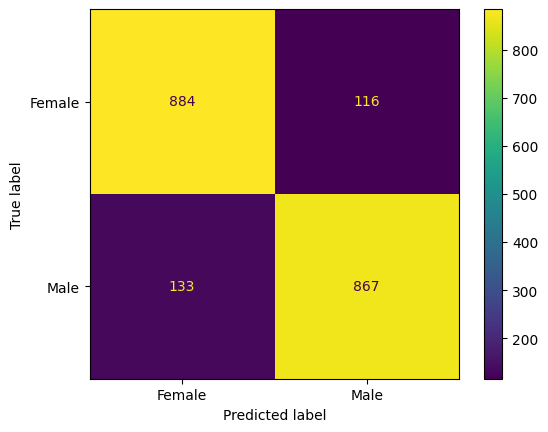

In [11]:
cm2 = confusion_matrix(y_test, stacking_predictions)
ConfusionMatrixDisplay(cm2, display_labels=['Female', 'Male']).plot()

In [13]:
stacking_model.feature_names_in_[0]

'Height'

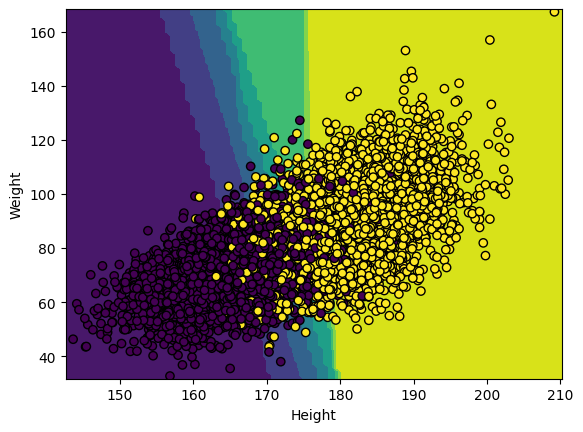

In [20]:
disp_stack = DecisionBoundaryDisplay.from_estimator(stacking_model, X_train)
disp_stack.ax_.scatter(X_train['Height'], X_train['Weight'], c=y_train,
                  edgecolor="k")

## Pojedynczy model - algorytm wyjściowy w modelach blendingowym i stackingowym.

In [37]:
%%time

meta_model_clas.fit(X_train, y_train)
single_predictions_clas = meta_model_clas.predict(X_test)
print(f'Single model accuracy: {accuracy_score(y_test, single_predictions_clas)}')

Single model accuracy: 0.868
CPU times: user 102 ms, sys: 2.89 ms, total: 105 ms
Wall time: 60 ms


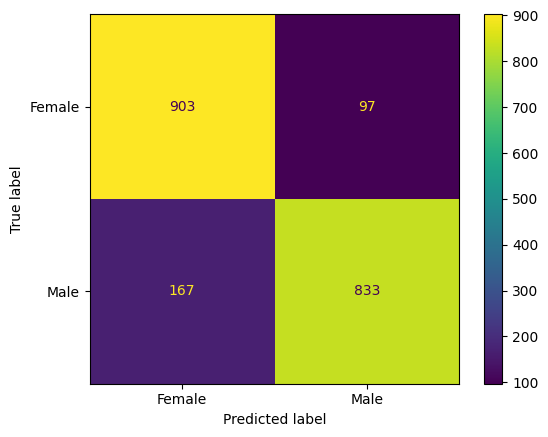

In [22]:
cm3 = confusion_matrix(y_test, single_predictions_clas)
ConfusionMatrixDisplay(cm3, display_labels=['Female', 'Male']).plot()

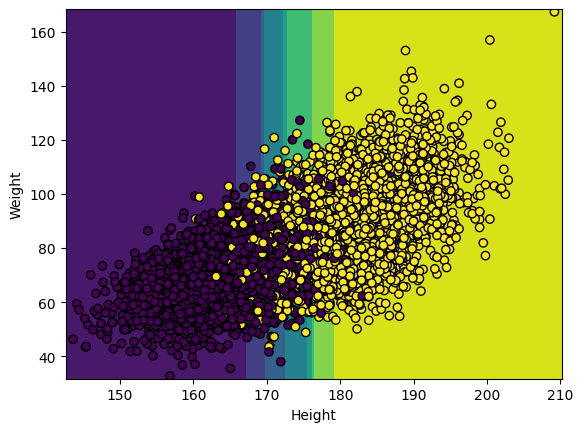

In [23]:
disp_single = DecisionBoundaryDisplay.from_estimator(meta_model_clas, X_train)
disp_single.ax_.scatter(X_train['Height'], X_train['Weight'], c=y_train,
                  edgecolor="k")

# Regresja.

## Przekształcenie cech - One-Hot Encoding.

In [25]:
bins = [0, 16.5, 18.5, 25, 30, 35, 40, 50]
df['BMI_Class'] = pd.cut(df['BMI'], bins=bins,
                         labels=['Severely_underweight', 'Underweight', 'Normal', 'Overweight', 'Obesity class I', 'Obesity class II', 'Obesity class III'])
df

,Height,BMI,Sex,Weight,BMI_Class
0,173.0,29.70,Male,88.9,Overweight
1,175.8,34.24,Male,105.8,Obesity class I
2,174.1,27.57,Male,83.6,Overweight
3,179.9,25.90,Male,83.8,Overweight
4,184.6,26.72,Male,91.1,Overweight
...,...,...,...,...,...
9995,176.0,22.38,Female,69.3,Normal
9996,169.0,27.36,Female,78.1,Overweight
9997,155.7,25.05,Female,60.7,Overweight
9998,181.3,24.38,Female,80.1,Normal


In [26]:
df = pd.get_dummies(data=df, columns=['Sex', 'BMI_Class'], prefix_sep='_Is_')
df

,Height,BMI,Weight,Sex_Is_Female,Sex_Is_Male,BMI_Class_Is_Severely_underweight,BMI_Class_Is_Underweight,BMI_Class_Is_Normal,BMI_Class_Is_Overweight,BMI_Class_Is_Obesity class I,BMI_Class_Is_Obesity class II,BMI_Class_Is_Obesity class III
0,173.0,29.70,88.9,0,1,0,0,0,1,0,0,0
1,175.8,34.24,105.8,0,1,0,0,0,0,1,0,0
2,174.1,27.57,83.6,0,1,0,0,0,1,0,0,0
3,179.9,25.90,83.8,0,1,0,0,0,1,0,0,0
4,184.6,26.72,91.1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,176.0,22.38,69.3,1,0,0,0,1,0,0,0,0
9996,169.0,27.36,78.1,1,0,0,0,0,1,0,0,0
9997,155.7,25.05,60.7,1,0,0,0,0,1,0,0,0
9998,181.3,24.38,80.1,1,0,0,0,1,0,0,0,0


## Podział na zmienne niezależne i zmienną zależną, usunięcie zbędnych zmiennych.

In [27]:
X_reg = df.drop(columns=['Height', 'BMI'])
y_reg = df[['Height']].values

In [28]:
X_reg

,Weight,Sex_Is_Female,Sex_Is_Male,BMI_Class_Is_Severely_underweight,BMI_Class_Is_Underweight,BMI_Class_Is_Normal,BMI_Class_Is_Overweight,BMI_Class_Is_Obesity class I,BMI_Class_Is_Obesity class II,BMI_Class_Is_Obesity class III
0,88.9,0,1,0,0,0,1,0,0,0
1,105.8,0,1,0,0,0,0,1,0,0
2,83.6,0,1,0,0,0,1,0,0,0
3,83.8,0,1,0,0,0,1,0,0,0
4,91.1,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
9995,69.3,1,0,0,0,1,0,0,0,0
9996,78.1,1,0,0,0,0,1,0,0,0
9997,60.7,1,0,0,0,0,1,0,0,0
9998,80.1,1,0,0,0,1,0,0,0,0


In [29]:
y_reg

array([[173. ],
       [175.8],
       [174.1],
       ...,
       [155.7],
       [181.3],
       [172.6]])

## Skalowanie danych, podział zbiorów.

In [30]:
scaler_x = RobustScaler()
X_reg['Weight'] = scaler_x.fit_transform(X_reg[['Weight']])

In [31]:
X_reg

,Weight,Sex_Is_Female,Sex_Is_Male,BMI_Class_Is_Severely_underweight,BMI_Class_Is_Underweight,BMI_Class_Is_Normal,BMI_Class_Is_Overweight,BMI_Class_Is_Obesity class I,BMI_Class_Is_Obesity class II,BMI_Class_Is_Obesity class III
0,0.440367,0,1,0,0,0,1,0,0,0
1,1.215596,0,1,0,0,0,0,1,0,0
2,0.197248,0,1,0,0,0,1,0,0,0
3,0.206422,0,1,0,0,0,1,0,0,0
4,0.541284,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...
9995,-0.458716,1,0,0,0,1,0,0,0,0
9996,-0.055046,1,0,0,0,0,1,0,0,0
9997,-0.853211,1,0,0,0,0,1,0,0,0
9998,0.036697,1,0,0,0,1,0,0,0,0


In [32]:
scaler_y = RobustScaler()

y_reg = scaler_y.fit_transform(y_reg)
y_reg

array([[-0.00653595],
       [ 0.17647059],
       [ 0.06535948],
       ...,
       [-1.1372549 ],
       [ 0.53594771],
       [-0.03267974]])

In [33]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=1)

## Model blendingowy.

In [34]:
%%time

base_models_reg = [
    ('Ridge', Ridge(), {'alpha': [0.1, 1, 10], 'solver': ['auto', 'svd', 'sag', 'saga']}),
    ('Lasso', Lasso(), {'alpha': [0.1, 1, 10], 'max_iter': [500, 1000], 'tol': [0.001, 0.01, 0.1]}),
    ('K-Neighbors Regressor', KNeighborsRegressor(), {'n_neighbors': [5, 10, 15], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree']}),
    ('Linear Regression', make_pipeline(PolynomialFeatures(), LinearRegression()), {'linearregression__fit_intercept': [True, False],
                                                                                    'linearregression__positive': [True, False],
                                                                                    'polynomialfeatures__degree': [1,2,3]})
]

meta_model_reg = LinearSVR()

predictions_train = []
predictions_test = []

for name, model, params in base_models_reg:
    if name == 'Linear Regression':
        poly_model = make_pipeline(PolynomialFeatures(), LinearRegression())
        grid_search = GridSearchCV(poly_model, params, cv=3)
        grid_search.fit(X_train_reg, y_train_reg)

        best_model = grid_search.best_estimator_

        train_pred = best_model.predict(X_train_reg)
        test_pred = best_model.predict(X_test_reg)

        print(f'{name} (Polynomial Degree {grid_search.best_params_["polynomialfeatures__degree"]}) - Best Parameters: {grid_search.best_params_}')
        print(f'{name} training MAE: {mean_absolute_error(y_train_reg, train_pred)}')
        print(f'{name} test MAE: {mean_absolute_error(y_test_reg, test_pred)}')
        print('_____________________________________________________\n')

        predictions_train.append(train_pred.reshape(-1, 1))
        predictions_test.append(test_pred.reshape(-1, 1))
    else:
        grid_search = GridSearchCV(model, params, cv=3)
        grid_search.fit(X_train_reg, y_train_reg)

        best_model = grid_search.best_estimator_

        train_pred = best_model.predict(X_train_reg)
        test_pred = best_model.predict(X_test_reg)

        print(f'{name} - Best Parameters: {grid_search.best_params_}')
        print(f'{name} training MAE: {mean_absolute_error(y_train_reg, train_pred)}')
        print(f'{name} test MAE: {mean_absolute_error(y_test_reg, test_pred)}')
        print('_____________________________________________________\n')

        predictions_train.append(train_pred.reshape(-1, 1))
        predictions_test.append(test_pred.reshape(-1, 1))

predictions_train = np.hstack(predictions_train)
predictions_test = np.hstack(predictions_test)
meta_params = {
    'C': [0.1, 1, 10],
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'epsilon': [0.01, 0.1, 0.2]
}
meta_model_reg.fit(predictions_train, y_train_reg)

meta_model_grid_search = GridSearchCV(meta_model_reg, meta_params, cv=3)
meta_model_grid_search.fit(predictions_train, y_train_reg)

best_meta_model = meta_model_grid_search.best_estimator_
blending_predictions = best_meta_model.predict(predictions_test)

print(f'Meta Model (LinearSVR) - Best Parameters: {meta_model_grid_search.best_params_}')
print(f'Meta Model (LinearSVR) - R2 Score: {r2_score(y_test_reg, blending_predictions)}')
print(f'Meta Model (LinearSVR) - MAE: {mean_absolute_error(y_test_reg, blending_predictions)}')
print(f'Meta Model (LinearSVR) - MSE: {mean_squared_error(y_test_reg, blending_predictions)}')

Ridge - Best Parameters: {'alpha': 0.1, 'solver': 'sag'}
Ridge training MAE: 0.20882579685340255
Ridge test MAE: 0.21660760673824178
_____________________________________________________

Lasso - Best Parameters: {'alpha': 0.1, 'max_iter': 500, 'tol': 0.1}
Lasso training MAE: 0.34937505784343764
Lasso test MAE: 0.35409385409770266
_____________________________________________________

K-Neighbors Regressor - Best Parameters: {'algorithm': 'auto', 'n_neighbors': 15, 'weights': 'uniform'}
K-Neighbors Regressor training MAE: 0.19573779956427
K-Neighbors Regressor test MAE: 0.2129753812636164
_____________________________________________________

Linear Regression (Polynomial Degree 2) - Best Parameters: {'linearregression__fit_intercept': True, 'linearregression__positive': True, 'polynomialfeatures__degree': 2}
Linear Regression training MAE: 0.20446153987311055
Linear Regression test MAE: 0.21139127444597616
_____________________________________________________

Meta Model (LinearSVR) -

## Model stackingowy.

In [35]:
%%time

base_models_reg = [
    ('Ridge', Ridge(alpha=0.1, solver='sag')),
    ('Lasso', Lasso(alpha=0.1, max_iter=500, tol=0.001)),
    ('K-Neighbors Regressor', KNeighborsRegressor(n_neighbors=15, algorithm='auto', weights='uniform')),
    ('Linear Regression', make_pipeline(PolynomialFeatures(degree=2), LinearRegression(fit_intercept=True, positive=True)))
]

meta_model_reg = LinearSVR(C=1, epsilon= 0.01, loss='squared_epsilon_insensitive')

stacking_model = StackingRegressor(estimators=base_models_reg, final_estimator=meta_model_reg)
stacking_model.fit(X_train_reg, y_train_reg)
stacking_predictions = stacking_model.predict(X_test_reg)
print(f'Stacking model - R2 Score: {r2_score(y_test_reg, stacking_predictions)}')
print(f'Stacking model - MAE: {mean_absolute_error(y_test_reg, stacking_predictions)}')
print(f'Stacking model - MSE: {mean_squared_error(y_test_reg, stacking_predictions)}')

Stacking model - R2 Score: 0.8470094113385379
Stacking model - MAE: 0.21046953211107758
Stacking model - MSE: 0.0683279993627983
CPU times: user 1.24 s, sys: 804 ms, total: 2.04 s
Wall time: 1.2 s


## Pojedynczy model.

In [36]:
meta_model_reg.fit(X_train_reg, y_train_reg)
single_predictions = meta_model_reg.predict(X_test_reg)
print(f'Single Model (LinearSVR) - R2 Score: {r2_score(y_test_reg, single_predictions)}')
print(f'Single Model (LinearSVR) - MAE: {mean_absolute_error(y_test_reg, single_predictions)}')
print(f'Single Model (LinearSVR) - MSE: {mean_squared_error(y_test_reg, single_predictions)}')

Single Model (LinearSVR) - R2 Score: 0.8374001959437625
Single Model (LinearSVR) - MAE: 0.21659513335549724
Single Model (LinearSVR) - MSE: 0.07261962585509246
